In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

Generate a bunch of points where the covariance is a function of a latent variable

In [20]:
num_points = 1000
latent = np.random.uniform(0, 1, (num_points,))
def true_cov(latent):
    return np.array([[1, latent-0.5], [latent-0.5, 1]])
target = np.array([np.random.multivariate_normal([0,0], true_cov(latent_)) for latent_ in latent])

Plot all points and fit a multivariate Gaussian to them all to demonstrate the marginal distribution p(target) has a sparse probability density map (as opposed to the conditional density p(target|latent) which should be a tighter ellipse) and that the sample covariance is basically the identity (because the mean of the induced Wishart covariance distribution p(cov) = int_0^1 latent p(cov|latent) d latent is the identity)

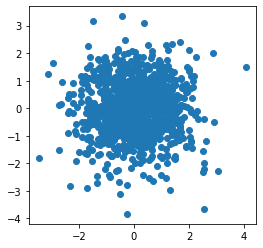

[[ 1.05154761 -0.00480822]
 [-0.00480822  1.04266182]]


In [23]:
plt.scatter(target[:,0], target[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
print(np.cov(target.T))

Now we try to estimate the mean of p(cov|latent) using a linear model with least squares (so we're allowed to look at true_cov)

In [34]:
from scipy.optimize import fmin

def pred_cov(w, b, latent_):
    return w * latent_ + b

def unwrap_cov(threevec):
    return np.array([[threevec[0], threevec[1]], [threevec[1], threevec[2]]])

def pred(p, latent_):
    return unwrap_cov(pred_cov(p[:3], p[3:], latent_))

def least_squares(p):
    w, b = p[:3], p[3:]
    preds = np.array([unwrap_cov(pred_cov(w, b, latent_)) for latent_ in latent])
    true = np.array([true_cov(latent_) for latent_ in latent])
    return np.sum(np.square(preds - true)).mean()

p = fmin(least_squares, np.array([1,1,1,0,0,0]))
print(p, '\n', least_squares(p))

Optimization terminated successfully.
         Current function value: 2.699556
         Iterations: 554
         Function evaluations: 869
[-0.03970821  0.89841199 -0.04478199  1.02689904 -0.4317469   1.03025483] 
 2.6995562099566097


Now we train without being allowed to look at true_cov or target in our loss function. We're only allowed target and latent

We fit the same linear model with a loss function of maximum likelihood

In [56]:
import math
def log_zeromean_multivariate_normal_pdf(x, cov):
    k = cov.shape[0]
    return -0.5 * (k * math.log(2*math.pi) + math.log(np.linalg.det(cov)) + x.T @ np.linalg.pinv(cov) @ x)

In [98]:
def neg_log_likelihood(p,d=True):
    w, b = p[:3], p[3:]
    preds = np.array([unwrap_cov(pred_cov(w, b, latent_)) for latent_ in latent])
    # quadratic term inside the multivariate normal PDF
    # this is proportional to log N(x|0,cov)
    scaled_p_values = []
    failed = 0
    for x, cov in zip(target, preds):
        if np.linalg.det(cov) > 0:
            scaled_p_values.append(log_zeromean_multivariate_normal_pdf(x, cov))
        else:
            failed += 1
            scaled_p_values.append(-999999)
    # if failed > 0: print(f"{failed/num_points:2%}")
    # elif not d: print(' '.join([f"{p:.2}" for p in scaled_p_values]))

    return -np.array(scaled_p_values).mean() # negate so fmin maximises likelihood

q = fmin(neg_log_likelihood, np.array([1,1,1,0,0,0]))

Optimization terminated successfully.
         Current function value: 2.832365
         Iterations: 591
         Function evaluations: 912


t: the weights that give rise to the true conditional covariance function

g: the weights that give rise to the global/marginal/unconditioned covariance matrix

q: our MLE solution without knowledge of the true covariance

p: our least squares solution with knowledge of true covariance

In [104]:
t = np.array([0, 1, 0, 1, -0.5, 1]) # true cov function
g = np.array([0, 0, 0, 1, 0, 1]) # global true cov
def P(k): return f"{math.exp(-neg_log_likelihood(k, d=False)):.2%}"
print('t: ', t, '\n', P(t), least_squares(t))
print('g: ', g, '\n', P(g), least_squares(g))
print('q: ', q, '\n', P(q), least_squares(q))
print('p: ', p, '\n', P(p), least_squares(p))

t:  [ 0.   1.   0.   1.  -0.5  1. ] 
 5.88% 0.0
g:  [0 0 0 1 0 1] 
 5.59% 167.46598141290644
q:  [-0.23920754  1.14918896 -0.05295913  1.20535002 -0.59888319  1.04718581] 
 5.89% 17.370827287070675
p:  [-0.03970821  0.89841199 -0.04478199  1.02689904 -0.4317469   1.03025483] 
 5.88% 2.6995562099566097
